In [2]:
import csv

# Brick and wall parameters (mm)
BRICK_L = 200  # mm
BRICK_W = 100
BRICK_H = 100
WALL_THICKNESS = 200  # mm

MAX_BRICKS = 10000

# Convert mm to grid units (100 mm base)
UNIT = 100
t = WALL_THICKNESS // UNIT  
brick_len = BRICK_L // UNIT  
brick_w = BRICK_W // UNIT    
brick_h = BRICK_H // UNIT    


def brick_count(L, W, H):
    """Compute total bricks for given outer grid size (100 mm units)."""
    shell_cells = L * W * H - (L - 2 * t) * (W - 2 * t) * (H - 2 * t)
    return shell_cells // (brick_len)  # each brick occupies 2 grid cells (200mm)


# Step 1. Find max interior volume with <=10,000 bricks
best = None
for L in range(20, 120, 2):  # 2*100 mm steps
    for W in range(20, 120, 2):
        for H in range(10, 40, 2):
            bricks = brick_count(L, W, H)
            if bricks <= MAX_BRICKS:
                inner_vol = (L - 2 * t) * (W - 2 * t) * (H - 2 * t)
                if best is None or inner_vol > best[0]:
                    best = (inner_vol, L, W, H, bricks)

inner_vol, L, W, H, total_bricks = best
print(f"Best solution: L={L}, W={W}, H={H} (grid units), Bricks={total_bricks}")



Best solution: L=44, W=46, H=38 (grid units), Bricks=9896


In [5]:
rows = []
brick_id = 0

# Door and window positions in mm
door_x_min = 0
door_x_max = 9  # will define on front wall later (900 mm)
door_h_mm = 2100
window_x_min = 0
window_x_max = 12
window_h_mm = 1200
window_y_base = 1200  # window bottom height

for z in range(H):  # height layers
    for y in range(W):
        for x in range(L):
            # Skip interior hollow
            if (t <= x < L - t) and (t <= y < W - t) and (t <= z < H - t):
                continue

            # Place brick only if starting position aligns with brick length (200mm = 2 grid)
            if x % 2 == 0:
                brick_id += 1
                x_mm = x * UNIT
                y_mm = y * UNIT
                z_mm = z * UNIT
                orientation = "X"  # along X-axis
                active = 1

                # Door removal on front wall (y = 0)
                if y < t:
                    if (x_mm >= 1000 and x_mm <= 1900) and (z_mm < door_h_mm):
                        active = 0

                # Window removal on right wall (x ≈ L-t)
                if x >= L - t:
                    if (z_mm >= window_y_base and z_mm < window_y_base + window_h_mm) and (y_mm >= 2500 and y_mm <= 3700):
                        active = 0

                rows.append([brick_id, x_mm, y_mm, z_mm, orientation, active])

# Step 3. Save to CSV
with open("placement.csv", "w", newline="") as f:
    writer = csv.writer(f)
    writer.writerow(["brick_id", "x_mm", "y_mm", "z_mm", "orientation", "active"])
    writer.writerows(rows)

print(f"Wrote {len(rows)} bricks to placement.csv")

Wrote 9896 bricks to placement.csv


In [6]:
#!/usr/bin/env python3
"""
render.py

Usage:
    python render.py [placement.csv]

If no argument is given or the first arg is '-f' (Jupyter), the script uses 'placement.csv' by default.

Output:
    top_view.png   -> plan view (X vs Y). Shows the top-most visible brick color per footprint.
    side_view.png  -> elevation (X vs Z). Draws bricks by z-level so stacking is visible.

Expected CSV columns:
    brick_id,x_mm,y_mm,z_mm,orientation,hide
If 'hide' is missing, 'active' is used (active==0 treated as hidden).
Coordinates are in mm; grid unit = 100 mm. Brick size = 200 x 100 x 100 mm -> spans 2x1x1 cells.
"""
import csv, sys, os
from PIL import Image, ImageDraw, ImageFont

UNIT = 100  # mm per grid cell
CELL_PIXEL = 8  # pixels per grid cell when rendering (tweak to change image size)

# Colors
COLOR_X = (200, 60, 60)   # X oriented bricks (red)
COLOR_Y = (60, 160, 80)   # Y oriented bricks (green)
COLOR_Z = (60, 110, 200)  # Z oriented bricks (blue)
COLOR_HIDDEN = (240, 240, 240)
BG = (255, 255, 255)
GRID_COLOR = (220, 220, 220)
LEGEND_BG = (250, 250, 250)

def safe_int(val, default=0):
    try:
        return int(float(val))
    except:
        return default

def read_csv(path):
    rows = []
    with open(path, newline='') as f:
        reader = csv.DictReader(f)
        for r in reader:
            rows.append(r)
    return rows

def normalize(rows):
    """Return list of bricks with integer cell coords and visibility flag."""
    bricks = []
    for r in rows:
        x_mm = safe_int(r.get('x_mm', 0))
        y_mm = safe_int(r.get('y_mm', 0))
        z_mm = safe_int(r.get('z_mm', 0))
        x_cell = x_mm // UNIT
        y_cell = y_mm // UNIT
        z_cell = z_mm // UNIT
        orient = (r.get('orientation') or r.get('orient') or '').strip().upper() or 'X'
        # hide precedence: 'hide' if present else use inverse of active (active==0 -> hidden)
        hide_val = r.get('hide', '').strip()
        if hide_val != '':
            hidden = (safe_int(hide_val) == 0)
        else:
            if 'active' in r and r['active'].strip() != '':
                hidden = (safe_int(r.get('active', 1)) == 0)
            else:
                hidden = False
        bricks.append({
            'brick_id': r.get('brick_id',''),
            'x_cell': x_cell,
            'y_cell': y_cell,
            'z_cell': z_cell,
            'orientation': orient,
            'visible': (not hidden)
        })
    return bricks

def compute_grid(bricks):
    max_x = 0; max_y = 0; max_z = 0
    for b in bricks:
        x = b['x_cell']; y = b['y_cell']; z = b['z_cell']
        if b['orientation'] == 'X':
            span_x = 2; span_y = 1
        elif b['orientation'] == 'Y':
            span_x = 1; span_y = 2
        else:
            span_x = 1; span_y = 1
        max_x = max(max_x, x + span_x)
        max_y = max(max_y, y + span_y)
        max_z = max(max_z, z + 1)
    # add small margin
    return max_x + 1, max_y + 1, max_z + 1

def color_for(orient):
    if orient == 'X': return COLOR_X
    if orient == 'Y': return COLOR_Y
    return COLOR_Z

def draw_top(bricks, grid_x, grid_y, out_path='top_view.png'):
    # For each footprint cell (x,y) choose the visible brick with highest z
    top_map = {}  # (x,y) -> (z, color)
    for b in bricks:
        if not b['visible']: continue
        x = b['x_cell']; y = b['y_cell']; z = b['z_cell']
        orient = b['orientation']
        if orient == 'X':
            cells = [(x,y),(x+1,y)]
        elif orient == 'Y':
            cells = [(x,y),(x,y+1)]
        else:
            cells = [(x,y)]
        col = color_for(orient)
        for (cx,cy) in cells:
            key = (cx,cy)
            prev = top_map.get(key)
            if prev is None or z >= prev[0]:
                top_map[key] = (z, col)

    W = grid_x * CELL_PIXEL
    H = grid_y * CELL_PIXEL
    img = Image.new('RGB', (W+1, H+1), BG)
    draw = ImageDraw.Draw(img)
    # grid lines
    for gx in range(0, W+1, CELL_PIXEL):
        draw.line([(gx,0),(gx,H)], fill=GRID_COLOR)
    for gy in range(0, H+1, CELL_PIXEL):
        draw.line([(0,gy),(W,gy)], fill=GRID_COLOR)

    # draw cells
    for (cx,cy), (z,col) in top_map.items():
        left = cx * CELL_PIXEL
        top = cy * CELL_PIXEL
        right = left + CELL_PIXEL - 1
        bottom = top + CELL_PIXEL - 1
        draw.rectangle([left, top, right, bottom], fill=col, outline=(0,0,0))

    # legend
    draw.rectangle([(5,5),(200,75)], fill=LEGEND_BG, outline=(0,0,0))
    draw.rectangle([(12,12),(32,32)], fill=COLOR_X, outline=(0,0,0)); draw.text((36,12),"X-orient", fill=(0,0,0))
    draw.rectangle([(12,34),(32,54)], fill=COLOR_Y, outline=(0,0,0)); draw.text((36,34),"Y-orient", fill=(0,0,0))
    draw.rectangle([(12,56),(32,76)], fill=COLOR_Z, outline=(0,0,0)); draw.text((36,56),"Z-orient", fill=(0,0,0))

    img.save(out_path)
    print("Saved", out_path)

def draw_side(bricks, grid_x, grid_z, out_path='side_view.png'):
    # Draw bricks by their X-span and Z-level; bricks at higher z overwrite lower ones when drawn later.
    W = grid_x * CELL_PIXEL
    H = grid_z * CELL_PIXEL
    img = Image.new('RGB', (W+1, H+1), BG)
    draw = ImageDraw.Draw(img)
    # grid lines
    for gx in range(0, W+1, CELL_PIXEL):
        draw.line([(gx,0),(gx,H)], fill=GRID_COLOR)
    for gy in range(0, H+1, CELL_PIXEL):
        draw.line([(0,gy),(W,gy)], fill=GRID_COLOR)

    # sort bricks by z ascending so higher bricks drawn later
    sorted_bricks = sorted([b for b in bricks if b['visible']], key=lambda b: b['z_cell'])
    for b in sorted_bricks:
        x = b['x_cell']; z = b['z_cell']; orient = b['orientation']
        if orient == 'X':
            w_cells = 2
        else:
            # Y and Z both appear 1 cell wide in side view (Y runs into depth)
            w_cells = 1
        left = x * CELL_PIXEL
        right = left + w_cells * CELL_PIXEL - 1
        # top/bottom in pixel coords: Z=0 should be bottom
        top = H - (z + 1) * CELL_PIXEL
        bottom = H - z * CELL_PIXEL - 1
        draw.rectangle([left, top, right, bottom], fill=color_for(orient), outline=(0,0,0))

    # legend
    draw.rectangle([(5,5),(200,75)], fill=LEGEND_BG, outline=(0,0,0))
    draw.rectangle([(12,12),(32,32)], fill=COLOR_X, outline=(0,0,0)); draw.text((36,12),"X-orient", fill=(0,0,0))
    draw.rectangle([(12,34),(32,54)], fill=COLOR_Y, outline=(0,0,0)); draw.text((36,34),"Y-orient", fill=(0,0,0))
    draw.rectangle([(12,56),(32,76)], fill=COLOR_Z, outline=(0,0,0)); draw.text((36,56),"Z-orient", fill=(0,0,0))

    img.save(out_path)
    print("Saved", out_path)

def main():
    # pick csv path: prefer user arg, but fallback to 'placement.csv' (also handle Jupyter '-f')
    arg = None
    if len(sys.argv) >= 2 and sys.argv[1] not in ('-f','--file'):
        arg = sys.argv[1]
    csv_path = arg or 'placement.csv'
    if not os.path.exists(csv_path):
        print("CSV not found:", csv_path)
        print("Usage: python render.py placement.csv")
        sys.exit(1)

    rows = read_csv(csv_path)
    if not rows:
        print("No rows in CSV")
        sys.exit(1)
    bricks = normalize(rows)
    grid_x, grid_y, grid_z = compute_grid(bricks)
    print(f"Grid cells: X={grid_x}, Y={grid_y}, Z={grid_z}")

    draw_top(bricks, grid_x, grid_y, out_path='top_view.png')
    draw_side(bricks, grid_x, grid_z, out_path='side_view.png')

if __name__ == '__main__':
    main()


Grid cells: X=45, Y=47, Z=39
Saved top_view.png
Saved side_view.png


Loaded 9530 visible bricks.


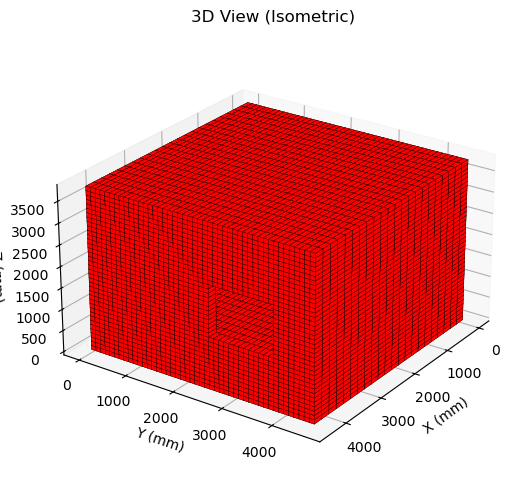

✅ Saved iso_view.png
✅ top_view.png, side_view.png, iso_view.png saved successfully.


In [7]:
#!/usr/bin/env python3

import sys, os, csv
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

def read_data(csv_path):
    df = pd.read_csv(csv_path)
    if 'hide' not in df.columns:
        df['hide'] = df.get('active', 1)
    df = df[df['hide'] != 0].copy()
    return df

import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Color map by orientation
def color_for(o):
    return {'X': 'red', 'Y': 'green', 'Z': 'blue'}.get(o, 'gray')

# Brick size in mm
BRICK_L, BRICK_W, BRICK_H = 200, 100, 100

# ------------------------
# 🧭 TOP VIEW (X–Y plane)
# ------------------------
def draw_top(df):
    fig, ax = plt.subplots(figsize=(6, 6))
    for _, row in df.iterrows():
        if hasattr(row, 'active') and row.active == 0:
            continue  # Skip hidden bricks
        
        if row.orientation == 'X':
            w, h = BRICK_L, BRICK_W
        elif row.orientation == 'Y':
            w, h = BRICK_W, BRICK_L
        else:
            w, h = BRICK_W, BRICK_W  # For Z-oriented, top area is small square
        
        rect = patches.Rectangle(
            (row.x_mm, row.y_mm), w, h,
            linewidth=0.4,
            edgecolor='black',
            facecolor=color_for(row.orientation),
            alpha=0.9
        )
        ax.add_patch(rect)

    ax.set_title("Top View (X–Y Plane)")
    ax.set_xlabel("X (mm)")
    ax.set_ylabel("Y (mm)")
    ax.axis('equal')
    ax.grid(True, alpha=0.3)
    plt.savefig("top_view.png", dpi=300, bbox_inches='tight')
    plt.close()


# ------------------------
# 🧱 SIDE VIEW (X–Z plane)
# ------------------------
def draw_side(df):
    fig, ax = plt.subplots(figsize=(6, 4))
    for _, row in df.iterrows():
        if hasattr(row, 'active') and row.active == 0:
            continue
        
        if row.orientation == 'Z':
            w, h = BRICK_W, BRICK_L  # Standing bricks
        else:
            w, h = BRICK_L, BRICK_H  # Normal horizontal brick
        
        rect = patches.Rectangle(
            (row.x_mm, row.z_mm), w, h,
            linewidth=0.4,
            edgecolor='black',
            facecolor=color_for(row.orientation),
            alpha=0.9
        )
        ax.add_patch(rect)

    ax.set_title("Side View (X–Z Plane)")
    ax.set_xlabel("X (mm)")
    ax.set_ylabel("Z (mm)")
    ax.axis('equal')
    ax.grid(True, alpha=0.3)
    plt.savefig("side_view.png", dpi=300, bbox_inches='tight')
    plt.close()


# ---------- 3D Isometric View ----------
def draw_iso(df):
    fig = plt.figure(figsize=(7,6))
    ax = fig.add_subplot(111, projection='3d')

    # Brick dimensions (mm)
    L, W, H = 200, 100, 100

    for _, row in df.iterrows():
        x, y, z = row.x_mm, row.y_mm, row.z_mm
        o = str(row.orientation).upper()
        if o == 'X':
            dx, dy, dz = L, W, H
        elif o == 'Y':
            dx, dy, dz = W, L, H
        else:
            dx, dy, dz = W, W, L

        color = color_for(o)

        # 8 corner points of brick
        X = [x, x+dx, x+dx, x, x, x+dx, x+dx, x]
        Y = [y, y, y+dy, y+dy, y, y, y+dy, y+dy]
        Z = [z, z, z, z, z+dz, z+dz, z+dz, z+dz]

        verts = [
            [(X[0],Y[0],Z[0]),(X[1],Y[1],Z[1]),(X[2],Y[2],Z[2]),(X[3],Y[3],Z[3])],
            [(X[4],Y[4],Z[4]),(X[5],Y[5],Z[5]),(X[6],Y[6],Z[6]),(X[7],Y[7],Z[7])],
            [(X[0],Y[0],Z[0]),(X[1],Y[1],Z[1]),(X[5],Y[5],Z[5]),(X[4],Y[4],Z[4])],
            [(X[2],Y[2],Z[2]),(X[3],Y[3],Z[3]),(X[7],Y[7],Z[7]),(X[6],Y[6],Z[6])],
            [(X[1],Y[1],Z[1]),(X[2],Y[2],Z[2]),(X[6],Y[6],Z[6]),(X[5],Y[5],Z[5])],
            [(X[4],Y[4],Z[4]),(X[7],Y[7],Z[7]),(X[3],Y[3],Z[3]),(X[0],Y[0],Z[0])]
        ]

        ax.add_collection3d(Poly3DCollection(verts, facecolors=color, linewidths=0.2, edgecolors='k', alpha=0.9))

    ax.set_xlabel("X (mm)")
    ax.set_ylabel("Y (mm)")
    ax.set_zlabel("Z (mm)")
    ax.view_init(25, 35)
    ax.set_box_aspect([1,1,0.6])
    plt.title("3D View (Isometric)")
    plt.savefig("iso_view.png", dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()
    print("✅ Saved iso_view.png")

# ---------- Main ----------
def main():
    csv_file = sys.argv[1] if len(sys.argv) > 1 and sys.argv[1] != "-f" else "placement.csv"
    if not os.path.exists(csv_file):
        print(f"CSV not found: {csv_file}")
        return
    df = read_data(csv_file)
    print(f"Loaded {len(df)} visible bricks.")
    draw_top(df)
    draw_side(df)
    draw_iso(df)
    print("✅ top_view.png, side_view.png, iso_view.png saved successfully.")

if __name__ == "__main__":
    main()


C:\Users\tarun\AppData\Local\Temp\ipykernel_10620\159426565.py:57: UserWarning: Glyph 128682 (\N{DOOR}) missing from font(s) DejaVu Sans.
  plt.savefig("door_side_view.png", dpi=300, bbox_inches='tight')
C:\ana\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128682 (\N{DOOR}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


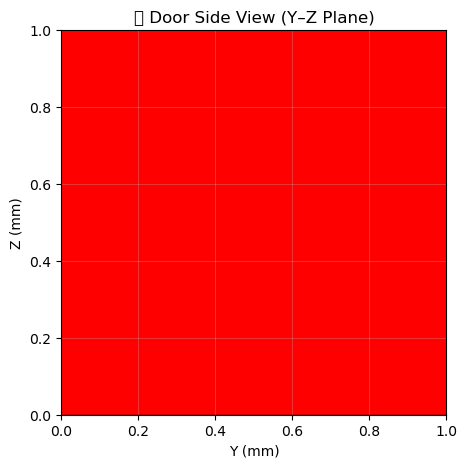

✅ Saved as door_side_view.png


In [12]:
# ======================================
# 🚪 DOOR SIDE VIEW (Y–Z plane)
# ======================================

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# --- Brick dimensions in mm ---
BRICK_L, BRICK_W, BRICK_H = 200, 100, 100

# --- Orientation color map ---
def color_for(o):
    return {'X': 'red', 'Y': 'green', 'Z': 'blue'}.get(o, 'gray')

# --- Door Side (Y–Z) View ---
def draw_door_side(df):
    fig, ax = plt.subplots(figsize=(7, 5))

    # Handle both 'active' or 'hide' flags
    if 'active' in df.columns:
        df = df[df['active'] == 1]
    elif 'hide' in df.columns:
        df = df[df['hide'] == 1]

    # Draw each visible brick as a rectangle
    for _, row in df.iterrows():
        if 'y_mm' not in row or 'z_mm' not in row:
            continue  # skip if coordinates missing

        # Brick projection on Y–Z plane
        if row.orientation == 'Y':
            w, h = BRICK_L, BRICK_H
        elif row.orientation == 'Z':
            w, h = BRICK_W, BRICK_L
        else:
            w, h = BRICK_W, BRICK_H

        rect = patches.Rectangle(
            (row.y_mm, row.z_mm),  # (Y, Z) base corner
            w, h,                  # width = along Y, height = along Z
            linewidth=0.3,
            edgecolor='black',
            facecolor=color_for(row.orientation),
            alpha=0.9
        )
        ax.add_patch(rect)

    # --- Plot setup ---
    ax.set_title("🚪 Door Side View (Y–Z Plane)")
    ax.set_xlabel("Y (mm)")
    ax.set_ylabel("Z (mm)")
    ax.set_aspect('equal', 'box')
    ax.grid(True, alpha=0.3)

    # Save and show
    plt.savefig("door_side_view.png", dpi=300, bbox_inches='tight')
    plt.show()
    print("✅ Saved as door_side_view.png")


# --- Example Run ---
# Make sure placement.csv exists in the same folder
df = pd.read_csv("placement.csv")
draw_door_side(df)


In [14]:
def carve_opening(wall, x_mm, z_mm, width_mm, height_mm):
    # Calculate bounds of the opening
    x_min = x_mm - width_mm/2
    x_max = x_mm + width_mm/2
    z_min = z_mm
    z_max = z_mm + height_mm

    # Load placement.csv → contains all bricks with x, y, z coordinates
    placement = pd.read_csv("placement.csv")

    # For the chosen wall (front/back/left/right)
    # Find all bricks that intersect the range (x_min, x_max, z_min, z_max)
    if wall == "front":
        mask = (
            (placement["y"] >= room_depth - 200) &  # front wall position
            (placement["x"] >= x_min) &
            (placement["x"] <= x_max) &
            (placement["z"] >= z_min) &
            (placement["z"] <= z_max)
        )

    # Hide those bricks
    placement.loc[mask, "hide"] = 1
    placement.to_csv("placement.csv", index=False)



In [15]:
def carve_opening(wall, x_mm, z_mm, width_mm, height_mm):
    placement = pd.read_csv("placement.csv")

    wall_thickness = 200
    room_depth = 4000

    x_min = x_mm - width_mm / 2
    x_max = x_mm + width_mm / 2
    z_min = z_mm
    z_max = z_mm + height_mm

    if wall == "front":
        mask = (
            (placement["y"] >= 3800 - wall_thickness) &
            (placement["x"] >= x_min) & (placement["x"] <= x_max) &
            (placement["z"] >= z_min) & (placement["z"] <= z_max)
        )
    elif wall == "back":
        mask = (
            (placement["y"] <= wall_thickness) &
            (placement["x"] >= x_min) & (placement["x"] <= x_max) &
            (placement["z"] >= z_min) & (placement["z"] <= z_max)
        )
    elif wall == "left":
        mask = (
            (placement["x"] <= wall_thickness) &
            (placement["y"] >= x_min) & (placement["y"] <= x_max) &
            (placement["z"] >= z_min) & (placement["z"] <= z_max)
        )
    elif wall == "right":
        mask = (
            (placement["x"] >= room_depth - wall_thickness) &
            (placement["y"] >= x_min) & (placement["y"] <= x_max) &
            (placement["z"] >= z_min) & (placement["z"] <= z_max)
        )
    else:
        raise ValueError(f"Unknown wall: {wall}")

    placement.loc[mask, "hide"] = 1
    placement.to_csv("placement.csv", index=False)
    print(f"✅ Carved {wall} opening at (x={x_mm}, z={z_mm}) size ({width_mm}x{height_mm})")


In [16]:
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# Notebook display
%matplotlib inline

# --- Room & brick parameters (edit these as needed) ---
ROOM_WIDTH = 4000   # x dimension in mm (left -> right)
ROOM_DEPTH = 3000   # y dimension in mm (back -> front)
ROOM_HEIGHT = 2400  # z dimension in mm (floor -> ceiling)

WALL_THICKNESS = 200  # mm
BRICK_SIZE = 200      # mm (assume cubic/regular bricks for grid centers)

PLACEMENT_CSV = Path("placement.csv")
OPENINGS_CSV = Path("openings.csv")


In [17]:
def generate_wall_placements(room_w=ROOM_WIDTH, room_d=ROOM_DEPTH, room_h=ROOM_HEIGHT,
                             wall_thick=WALL_THICKNESS, brick=BRICK_SIZE):
    """
    Create bricks as *centers* for each wall:
    - front (y ~ room_d - wall_thick/2)
    - back  (y ~ wall_thick/2)
    - left  (x ~ wall_thick/2)
    - right (x ~ room_w - wall_thick/2)
    Each brick entry: x, y, z, wall, hide(0/1)
    """
    placements = []
    half_brick = brick / 2.0

    # generate horizontal coords for walls (grid across wall width)
    x_coords = np.arange(half_brick, room_w, brick)  # centers along width
    y_coords = np.arange(half_brick, room_d, brick)  # centers along depth
    z_coords = np.arange(half_brick, room_h, brick)  # centers along height

    # Front wall (facing +y). Centers at y = room_d - wall_thick/2
    y_front = room_d - wall_thick / 2.0
    for x in x_coords:
        for z in z_coords:
            placements.append([x, y_front, z, "front", 0])

    # Back wall (facing 0 y). Centers at y = wall_thick/2
    y_back = wall_thick / 2.0
    for x in x_coords:
        for z in z_coords:
            placements.append([x, y_back, z, "back", 0])

    # Left wall (facing 0 x). Centers at x = wall_thick/2
    x_left = wall_thick / 2.0
    for y in y_coords:
        for z in z_coords:
            placements.append([x_left, y, z, "left", 0])

    # Right wall (facing +x). Centers at x = room_w - wall_thick/2
    x_right = room_w - wall_thick / 2.0
    for y in y_coords:
        for z in z_coords:
            placements.append([x_right, y, z, "right", 0])

    df = pd.DataFrame(placements, columns=["x", "y", "z", "wall", "hide"])
    return df

# Generate and save placements (overwrites existing placement.csv)
placement_df = generate_wall_placements()
placement_df.to_csv(PLACEMENT_CSV, index=False)
print(f"Generated {len(placement_df)} brick centers and saved to {PLACEMENT_CSV}")
placement_df.head()


Generated 840 brick centers and saved to placement.csv


,x,y,z,wall,hide
0,100.0,2900.0,100.0,front,0
1,100.0,2900.0,300.0,front,0
2,100.0,2900.0,500.0,front,0
3,100.0,2900.0,700.0,front,0
4,100.0,2900.0,900.0,front,0


In [22]:
# If user does not have openings.csv, create an example
if not OPENINGS_CSV.exists():
    sample = pd.DataFrame([
        # wall, x_mm (center), z_mm (bottom), width_mm, height_mm, type
        ["front", ROOM_WIDTH/2.0, 0, 900, 2100, "door"],  # centered front door
        ["right", 1200, 900, 1200, 900, "window"]        # example right-side window
    ], columns=["wall", "x_mm", "z_mm", "width_mm", "height_mm", "type"])
    sample.to_csv(OPENINGS_CSV, index=False)
    print(f"Created example {OPENINGS_CSV}")

openings_df = pd.read_csv(OPENINGS_CSV)
openings_df


,wall,x_mm,z_mm,width_mm,height_mm,type
0,front,2000,0,900,2100,door
1,right,1200,900,1200,900,window


In [23]:
def carve_opening(placement_csv=PLACEMENT_CSV, wall=None, x_mm=0, z_mm=0, width_mm=900, height_mm=2100,
                  wall_thick=WALL_THICKNESS, room_w=ROOM_WIDTH, room_d=ROOM_DEPTH):
    """
    Hide bricks (set hide=1) that intersect the rectangular opening.
    - wall: 'front'|'back'|'left'|'right'
    - x_mm: horizontal center measured along wall's horizontal axis (in world coords)
            For front/back -> x coordinate (0..room_w)
            For left/right -> y coordinate (0..room_d)
    - z_mm: bottom elevation from floor (0..room_h)
    - width_mm, height_mm: opening size
    """
    df = pd.read_csv(placement_csv)

    # Compute opening world bounding box (x_range, y_range, z_range)
    # Interpret x_mm differently for left/right (it will be along wall axis -> world y)
    half_w = width_mm / 2.0
    z_min = float(z_mm)
    z_max = float(z_mm) + float(height_mm)

    # default no mask
    mask = pd.Series([False] * len(df))

    if wall == "front":
        # opening spans along x; y around front wall center
        x_min, x_max = x_mm - half_w, x_mm + half_w
        y_center = room_d - wall_thick / 2.0
        y_min, y_max = y_center - wall_thick / 2.0 - 1e-6, y_center + wall_thick / 2.0 + 1e-6
        mask = (
            (df["wall"] == "front") &
            (df["x"] >= x_min) & (df["x"] <= x_max) &
            (df["z"] >= z_min) & (df["z"] <= z_max) &
            (df["y"] >= y_min) & (df["y"] <= y_max)
        )

    elif wall == "back":
        x_min, x_max = x_mm - half_w, x_mm + half_w
        y_center = wall_thick / 2.0
        y_min, y_max = y_center - wall_thick / 2.0 - 1e-6, y_center + wall_thick / 2.0 + 1e-6
        mask = (
            (df["wall"] == "back") &
            (df["x"] >= x_min) & (df["x"] <= x_max) &
            (df["z"] >= z_min) & (df["z"] <= z_max) &
            (df["y"] >= y_min) & (df["y"] <= y_max)
        )

    elif wall == "left":
        # for left wall x is near wall_thick/2; horizontal axis is y-direction
        y_min_world, y_max_world = x_mm - half_w, x_mm + half_w
        x_center = wall_thick / 2.0
        x_min, x_max = x_center - wall_thick / 2.0 - 1e-6, x_center + wall_thick / 2.0 + 1e-6
        mask = (
            (df["wall"] == "left") &
            (df["y"] >= y_min_world) & (df["y"] <= y_max_world) &
            (df["z"] >= z_min) & (df["z"] <= z_max) &
            (df["x"] >= x_min) & (df["x"] <= x_max)
        )

    elif wall == "right":
        y_min_world, y_max_world = x_mm - half_w, x_mm + half_w
        x_center = room_w - wall_thick / 2.0
        x_min, x_max = x_center - wall_thick / 2.0 - 1e-6, x_center + wall_thick / 2.0 + 1e-6
        mask = (
            (df["wall"] == "right") &
            (df["y"] >= y_min_world) & (df["y"] <= y_max_world) &
            (df["z"] >= z_min) & (df["z"] <= z_max) &
            (df["x"] >= x_min) & (df["x"] <= x_max)
        )
    else:
        raise ValueError(f"Unknown wall: {wall}")

    affected = mask.sum()
    if affected > 0:
        df.loc[mask, "hide"] = 1
        df.to_csv(placement_csv, index=False)
        print(f"Carved opening on '{wall}': center({x_mm},{z_mm}), size({width_mm}x{height_mm}) -> hid {affected} bricks")
    else:
        print(f"No bricks matched to carve on '{wall}' for opening center({x_mm},{z_mm}) size({width_mm}x{height_mm})")

    return affected


In [24]:
openings = pd.read_csv(OPENINGS_CSV)

print(f"Applying {len(openings)} openings from {OPENINGS_CSV} ...")
for idx, row in openings.iterrows():
    # handle numeric parsing (in case CSV stores as strings)
    wall = str(row["wall"]).strip().lower()
    x_mm = float(row["x_mm"])
    z_mm = float(row["z_mm"])
    width_mm = float(row["width_mm"])
    height_mm = float(row["height_mm"])
    carve_opening(PLACEMENT_CSV, wall, x_mm, z_mm, width_mm, height_mm)

# reload placement
placement_df = pd.read_csv(PLACEMENT_CSV)
placement_df["hide"] = placement_df["hide"].astype(int)
placement_df.head()


Applying 2 openings from openings.csv ...
Carved opening on 'front': center(2000.0,0.0), size(900.0x2100.0) -> hid 44 bricks
Carved opening on 'right': center(1200.0,900.0), size(1200.0x900.0) -> hid 30 bricks


,x,y,z,wall,hide
0,100.0,2900.0,100.0,front,0
1,100.0,2900.0,300.0,front,0
2,100.0,2900.0,500.0,front,0
3,100.0,2900.0,700.0,front,0
4,100.0,2900.0,900.0,front,0


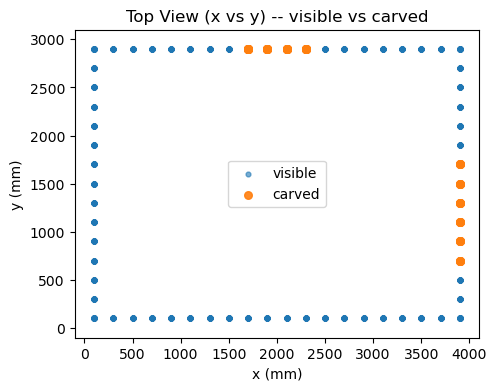

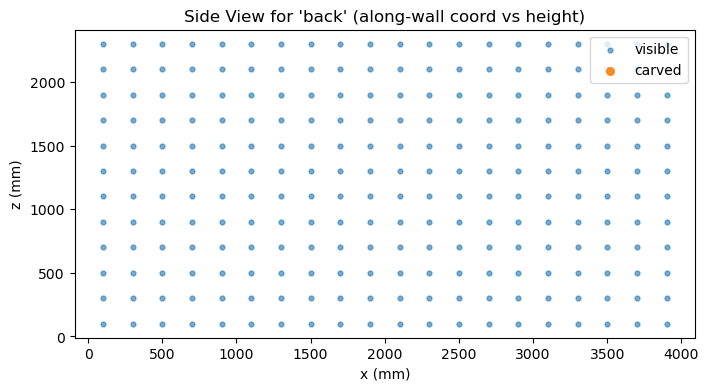

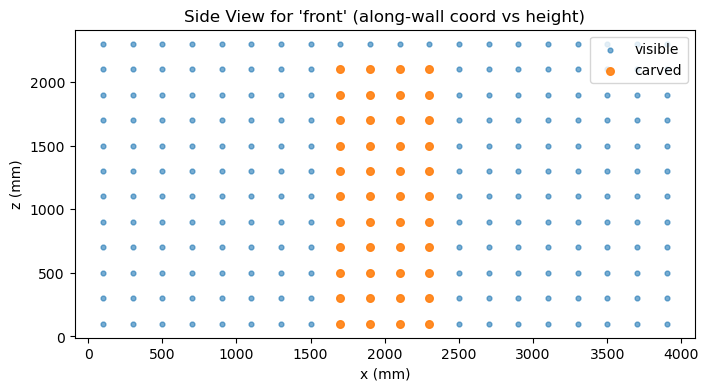

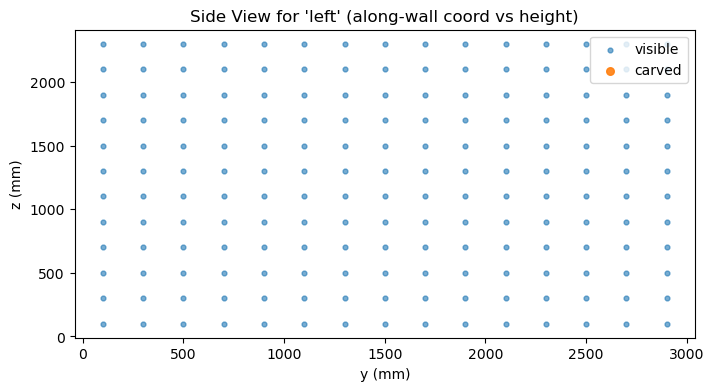

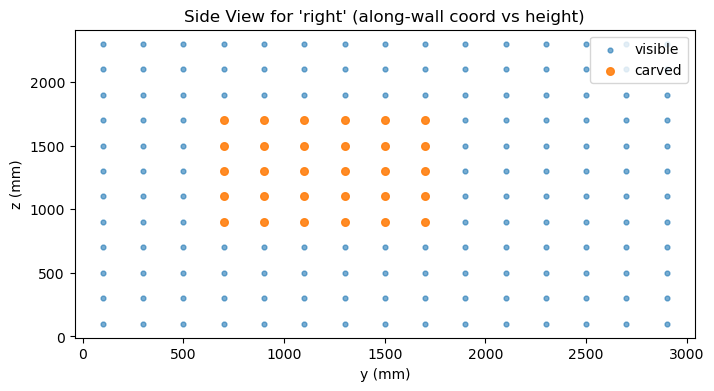

In [25]:
def plot_top_view(df, room_w=ROOM_WIDTH, room_d=ROOM_DEPTH):
    plt.figure(figsize=(6,4))
    vis = df[df["hide"]==0]
    hid = df[df["hide"]==1]
    plt.scatter(vis["x"], vis["y"], s=12, label="visible", alpha=0.6)
    plt.scatter(hid["x"], hid["y"], s=30, label="carved", alpha=0.9)
    plt.xlim(-100, room_w+100)
    plt.ylim(-100, room_d+100)
    plt.gca().set_aspect('equal', 'box')
    plt.title("Top View (x vs y) -- visible vs carved")
    plt.xlabel("x (mm)")
    plt.ylabel("y (mm)")
    plt.legend()
    plt.show()

def plot_side_view_for_wall(df, wall, room_w=ROOM_WIDTH, room_d=ROOM_DEPTH):
    """
    Side-view: horizontal axis = along-wall coordinate s (in mm),
               vertical axis = z (height)
    For front/back -> s = x
    For left/right -> s = y
    """
    if wall not in {"front","back","left","right"}:
        raise ValueError("wall must be one of front/back/left/right")
    mask = df["wall"] == wall
    sub = df[mask].copy()
    if sub.empty:
        print("No bricks for wall:", wall)
        return

    if wall in {"front","back"}:
        sub["s"] = sub["x"]
        s_label = "x (mm)"
    else:
        sub["s"] = sub["y"]
        s_label = "y (mm)"

    vis = sub[sub["hide"]==0]
    hid = sub[sub["hide"]==1]

    plt.figure(figsize=(8,4))
    plt.scatter(vis["s"], vis["z"], s=12, label="visible", alpha=0.6)
    plt.scatter(hid["s"], hid["z"], s=30, label="carved", alpha=0.9)
    plt.title(f"Side View for '{wall}' (along-wall coord vs height)")
    plt.xlabel(s_label)
    plt.ylabel("z (mm)")
    plt.legend()
    plt.show()

# Plot overall top view
placement_df = pd.read_csv(PLACEMENT_CSV)
plot_top_view(placement_df)

# Plot side views for each wall
for w in ["back", "front", "left", "right"]:
    plot_side_view_for_wall(placement_df, w)


In [27]:
openings = pd.read_csv("openings.csv")
print("✅ openings.csv loaded:")
display(openings.head())

✅ openings.csv loaded:


,wall,x_mm,z_mm,width_mm,height_mm,type
0,front,2000,0,900,2100,door
1,right,1200,900,1200,900,window
